# (e) Appendix.

In [1]:
import numpy as np
import heapq

class SimData:
    
    def __init__(self, time_arrive, event_type, is_priority, worker_start, worker_end):
        self.time_arrive = time_arrive # the time when the package arrives at the post-office
        self.event_type = event_type # "ARRIVAL" or "DEPARTURE_WORKER1", "DEPARTURE_WORKER2"...
        self.is_priority = bool(is_priority) # True if the package is priority package, False otherwise
        self.worker_start = worker_start # the time when a worker start processing this package
        self.worker_end = worker_end # the time when the worker finish the process
    
    def Print(self):
        print("{} ({}): {} start, {} end.".format(round(self.time_arrive, 3), 
                                                  "priority" if self.is_priority else "regular",
                                                  round(self.worker_start, 3), round(self.worker_end, 3)))

In [2]:
def SimSystem(T=2000, regular_prob=0.9, lmbda=4, mu=2, n_workers=9, n_burn_in=-1):
    
    ell = [] # store the event after finished
    event_queue = [] # store the events that are currently in the system
    priority_queue = [] # store the priority package when all the workers are busy
    regular_queue = [] # store the regular package when all the workers are busy
    
    # a list of arrival time of packages
    time_arr = []
    # a list of the length of the priority queue and regular queue
    pq_len = []
    rq_len = []
    
    workers_busy = {i: 0 for i in range(n_workers)} # worker status
    delta_busy_time = 0 # sum of all busy time
    all_busy_flag = 0 # workers are all busy or not
    burn_in_start_time = 0
    
    # create first arrival
    t_current = np.random.exponential(1/lmbda)

    # initialise the first event status
    data = SimData(t_current, "ARRIVAL", np.random.binomial(1, 1-regular_prob), -1, -1)
    heapq.heappush(event_queue, (t_current, data))

    # main loop
    while t_current < T:

        # take out the customer of current time
        t_current, event = heapq.heappop(event_queue)

        # record queues lenght
        time_arr.append(t_current)
        pq_len.append(len(priority_queue))
        rq_len.append(len(regular_queue))
        
        if len(ell) > n_burn_in:
            if (burn_in_start_time == 0) and (n_burn_in != -1):
                burn_in_start_time = t_current
                
            if (0 not in workers_busy.values()) and (not all_busy_flag): # start time of all busy
                all_busy_flag = 1
                all_busy_start = t_current

            elif (0 in workers_busy.values()) and (all_busy_flag): # end time of all busy
                all_busy_flag = 0
                delta_busy_time += (t_current - all_busy_start)

        # handle arrival
        if event.event_type == "ARRIVAL": 

            # schedule the next arrival
            t_next = t_current + np.random.exponential(1/lmbda)
            data = SimData(t_next, "ARRIVAL", np.random.binomial(1, 1-regular_prob), -1, -1)
            heapq.heappush(event_queue, (t_next, data))

            # if workers are not all busy, process the package
            if 0 in workers_busy.values():
                worker = list(workers_busy.values()).index(0) # which worker is free
                workers_busy[worker] = 1 # set this worker busy
                event.worker_start = t_current # assign the time when a worker start processing this package
                event.worker_end = t_current + np.random.exponential(mu) # assign the time when the worker finish the process
                event.event_type = "DEPARTURE_WORKER"+str(worker) # switch event_type to be "DEPARTURE_WORKER*"
                heapq.heappush(event_queue, (event.worker_end, event)) # put it into the event queue

            # if workers are all busy, store the package in the priority queue or regular queue
            else:
                choose_queue = priority_queue if event.is_priority else regular_queue
                choose_queue.append(event)

            continue

        # handle departure
        elif event.event_type.startswith('DEPARTURE_WORKER'):

            ell.append(event) # store the event into the ell list

            # takes a new package from one of the waiting queue if there are some
            choose_queue = priority_queue if len(priority_queue) else regular_queue
            if len(choose_queue) != 0:
                obj_wait_in_queue = choose_queue.pop(0) # take the package
                obj_wait_in_queue.worker_start = t_current # assign the time when a worker start processing this package
                obj_wait_in_queue.worker_end = t_current + np.random.exponential(mu) # assign the time when the worker finish the process
                obj_wait_in_queue.event_type = event.event_type # switch event type to be "DEPARTURE_WORKER*"
                heapq.heappush(event_queue, (obj_wait_in_queue.worker_end, obj_wait_in_queue)) # put it into the event queue

            # set the worker status to be 0 (not busy) if there is no package in both priority queue and regular queue
            else:
                worker = int(event.event_type[-1]) # which worker
                workers_busy[worker] = 0 # set worker not busy

            continue
            
    if all_busy_flag:
        delta_busy_time += (T - all_busy_start)
            
    return ell.copy(), delta_busy_time/(T-burn_in_start_time), time_arr.copy(), pq_len.copy(), rq_len.copy()

# 9 workers

In [ ]:
# simulate once
ell_9, _, time_arr, pq_len, rq_len = SimSystem()
# calculate the number of events that are considered as system burin-in
burn_in_9 = int(0.1*len(ell_9))
# have a look at all the events (packages)
for event in ell_9:
    event.Print()

<IPython.core.display.Javascript object>


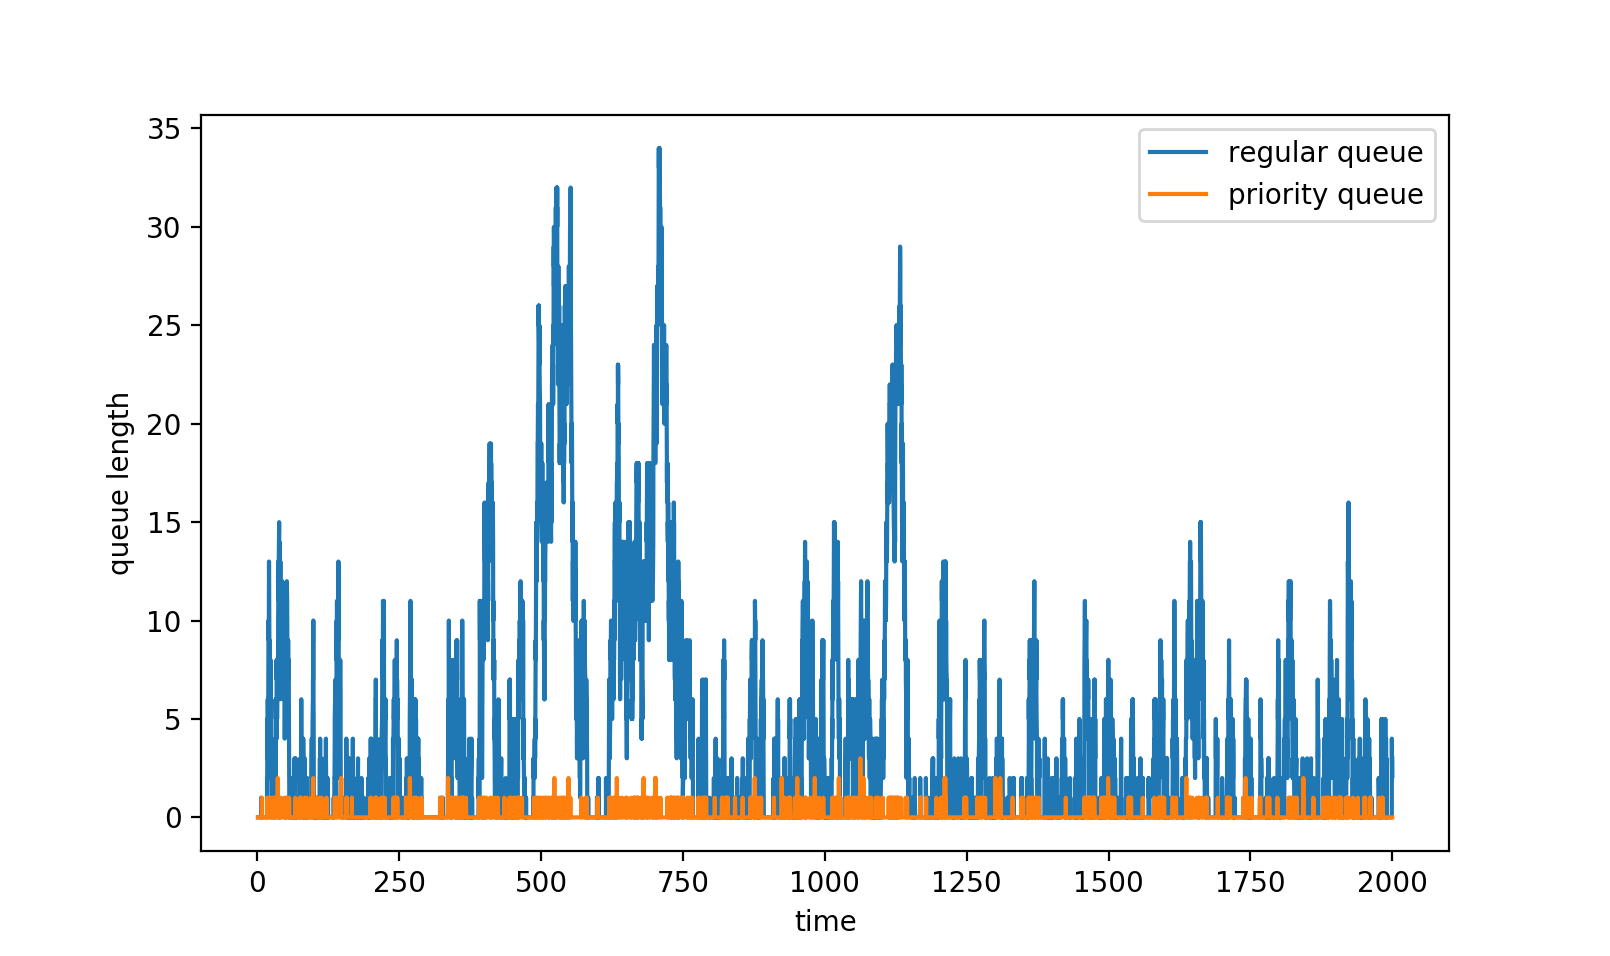

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

# length of queues against time
plt.plot(time_arr, rq_len, label = "regular queue")
plt.plot(time_arr, pq_len, label = "priority queue")
plt.xlabel("time")
plt.ylabel("queue length")
plt.legend()
plt.show()

In [5]:
# calculate the average waiting time
re_waiting_time = []
pr_waiting_time = []

for event in ell_9[burn_in_9:]:
    waiting_time = event.worker_end - event.time_arrive
    if event.is_priority:
        pr_waiting_time.append(waiting_time)
    else:
        re_waiting_time.append(waiting_time)

print("average waiting time of regular package is", np.mean(re_waiting_time))
print("average waiting time of priority package is", np.mean(pr_waiting_time))

average waiting time of regular package is 3.0814083174824685
average waiting time of priority package is 2.1451757359621966


In [6]:
# loop for n = 50 times and calculate CI

all_proportion = []

n = 50
for _ in range(n):
    
    _, proportion, _, _, _ = SimSystem(n_burn_in = burn_in_9)
    all_proportion.append(proportion)
    
mu = np.mean(all_proportion.copy())
S = np.std(all_proportion.copy())
print("95% CI for 9 workers: ({}, {})".format(mu-1.96*S/np.sqrt(n), mu+1.96*S/np.sqrt(n)))

95% CI for 9 workers: (0.6330333501498051, 0.6558744786775299)


# 10 workers

In [ ]:
# increase the number of workers to be 10
# simulate once
ell_10, _, time_arr, pq_len, rq_len = SimSystem(n_workers = 10)
# calculate the number of events that are considered as system burin-in
burn_in_10 = int(0.1*len(ell_10))
# have a look at all the events (packages)
for event in ell_10:
    event.Print()

<IPython.core.display.Javascript object>


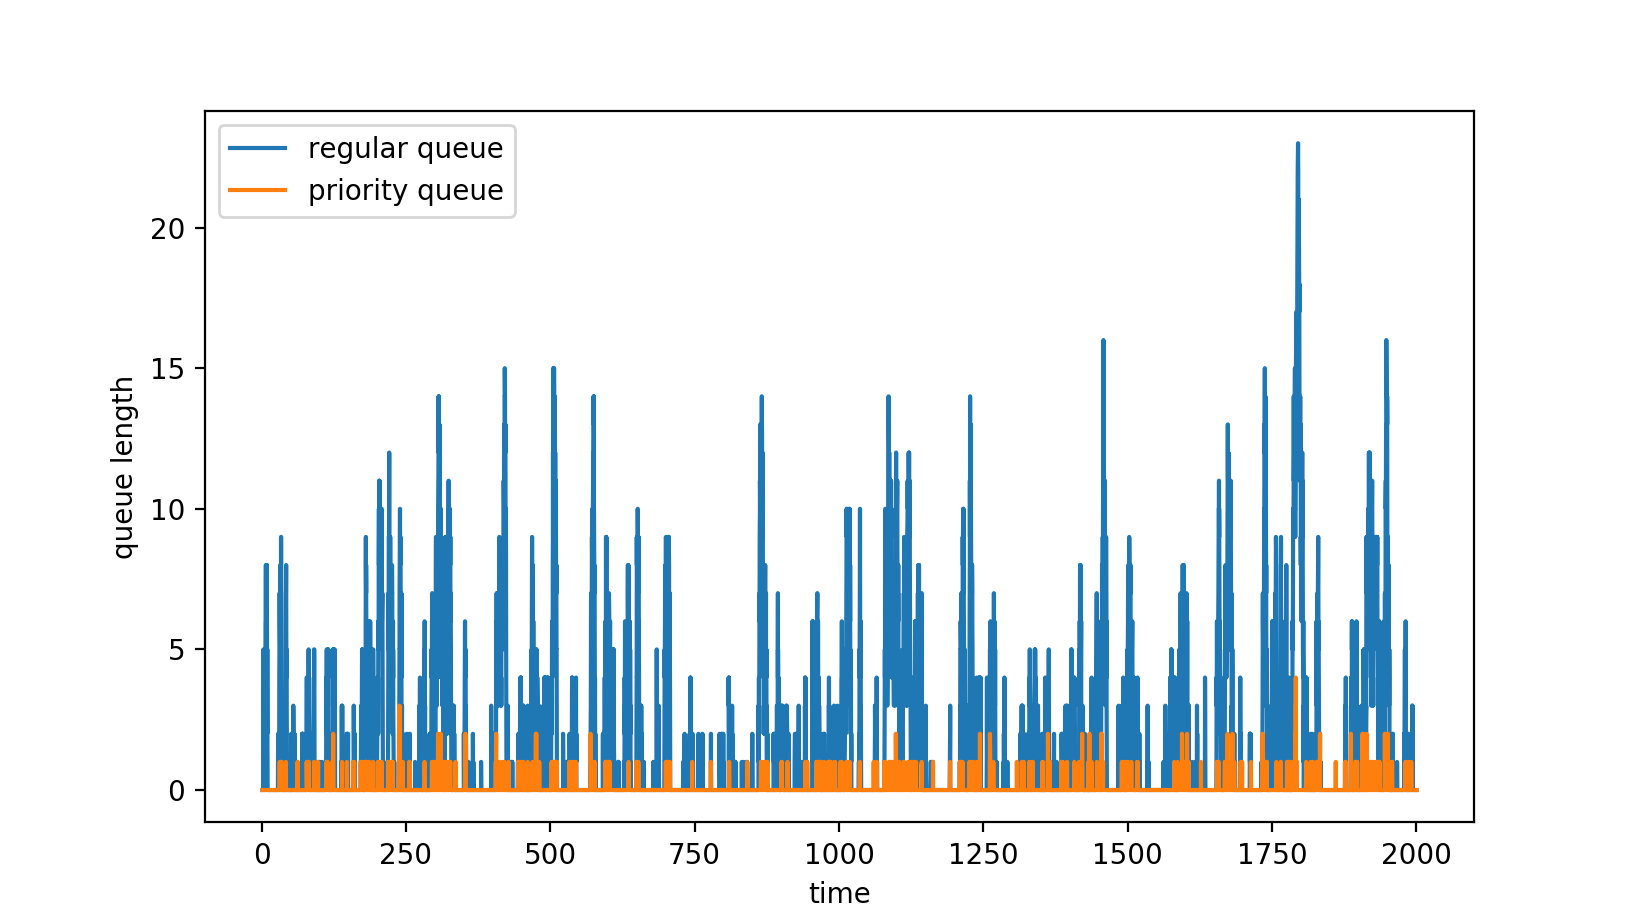

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt

# length of queues against time
plt.plot(time_arr, rq_len, label = "regular queue")
plt.plot(time_arr, pq_len, label = "priority queue")
plt.xlabel("time")
plt.ylabel("queue length")
plt.legend()
plt.show()

In [9]:
# calculate the average waiting time
re_waiting_time = []
pr_waiting_time = []

for event in ell_10[burn_in_10:]:
    waiting_time = event.worker_end - event.time_arrive
    if event.is_priority:
        pr_waiting_time.append(waiting_time)
    else:
        re_waiting_time.append(waiting_time)

print("average waiting time of regular package is", np.mean(re_waiting_time))
print("average waiting time of priority package is", np.mean(pr_waiting_time))

average waiting time of regular package is 2.4506530650324025
average waiting time of priority package is 2.1367808980462892


In [10]:
# loop for n = 50 times and calculate CI

all_proportion = []
n = 50
for _ in range(n):
    
    _, proportion, _, _, _ = SimSystem(n_workers = 10, n_burn_in = burn_in_10)
    all_proportion.append(proportion)
    
mu = np.mean(all_proportion.copy())
S = np.std(all_proportion.copy())
print("95% CI: ({}, {})".format(mu-1.96*S/np.sqrt(n), mu+1.96*S/np.sqrt(n)))

95% CI: (0.40253528819278295, 0.4184107823750163)


# 8 workers

In [ ]:
# decrease the number of workers to be 8
# simulate once
ell_8, _, time_arr, pq_len, rq_len = SimSystem(n_workers = 8)
# calculate the number of events that are considered as system burin-in
burn_in_8 = int(0.1*len(ell_8))
# have a look at all the events (packages)
for event in ell_8:
    event.Print()

<IPython.core.display.Javascript object>


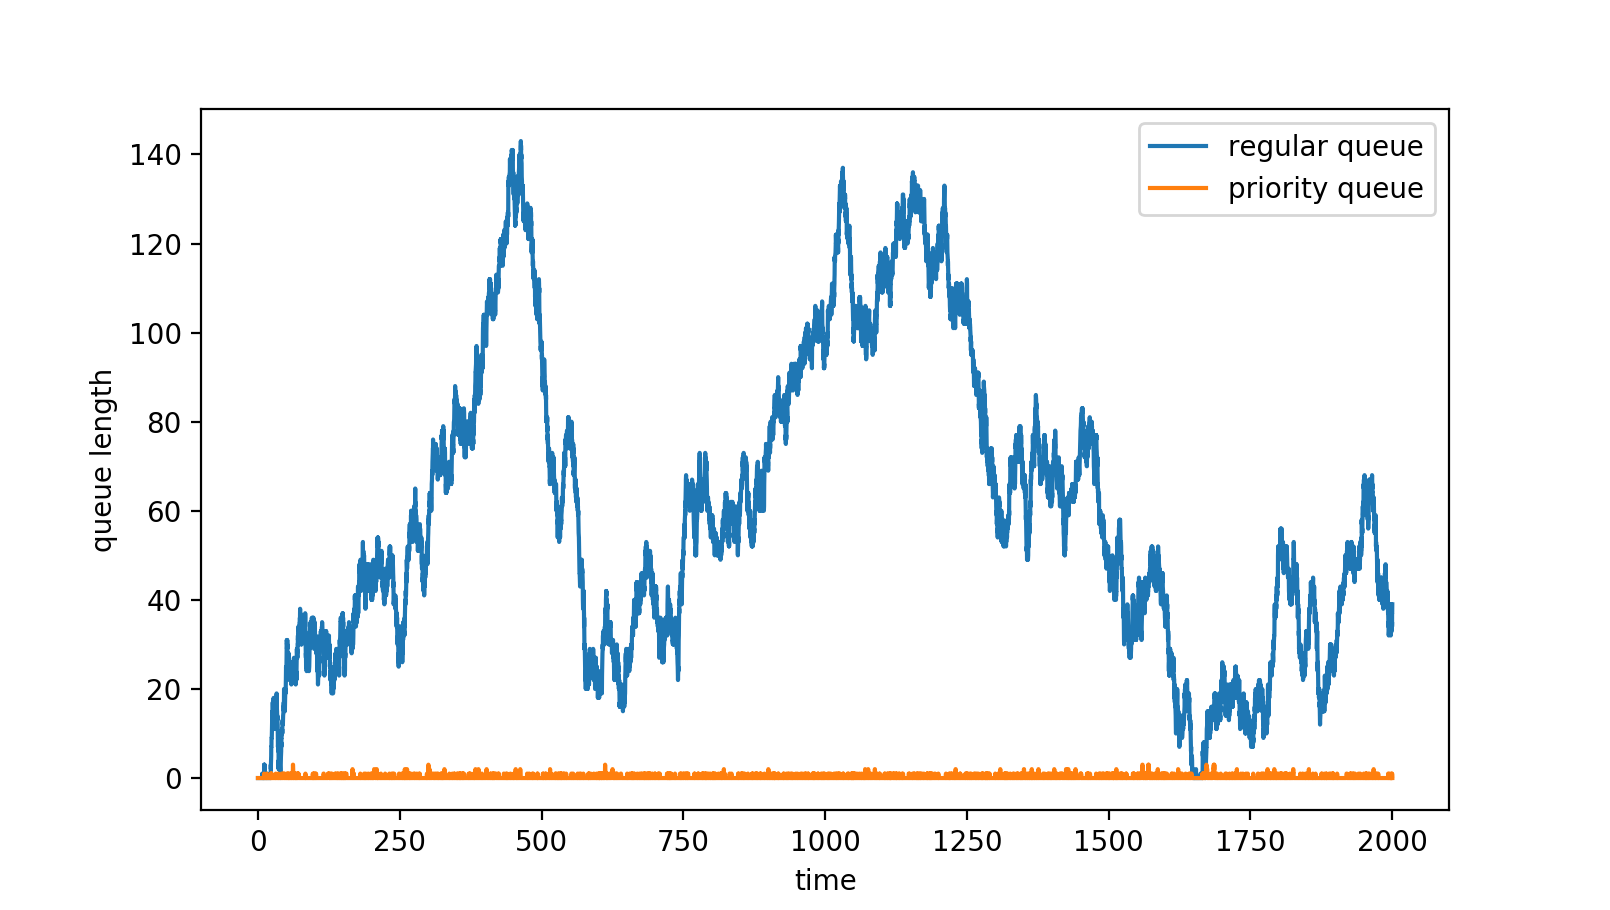

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt

# length of queues against time
plt.plot(time_arr, rq_len, label = "regular queue")
plt.plot(time_arr, pq_len, label = "priority queue")
plt.xlabel("time")
plt.ylabel("queue length")
plt.legend()
plt.show()

In [13]:
# calculate the average waiting time
re_waiting_time = []
pr_waiting_time = []

for event in ell_8[burn_in_8:]:
    waiting_time = event.worker_end - event.time_arrive
    if event.is_priority:
        pr_waiting_time.append(waiting_time)
    else:
        re_waiting_time.append(waiting_time)

print("average waiting time of regular package is", np.mean(re_waiting_time))
print("average waiting time of priority package is", np.mean(pr_waiting_time))

average waiting time of regular package is 19.83383954623125
average waiting time of priority package is 2.320083211562666


In [14]:
# loop for n = 50 times and calculate CI

all_proportion = []
n = 50
for _ in range(n):
    
    _, proportion, _, _, _ = SimSystem(n_workers = 8, n_burn_in = burn_in_8)
    all_proportion.append(proportion)
    
mu = np.mean(all_proportion.copy())
S = np.std(all_proportion.copy())
print("95% CI: ({}, {})".format(mu-1.96*S/np.sqrt(n), mu+1.96*S/np.sqrt(n)))

95% CI: (0.9645187443538906, 0.9793861163081893)
